In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


def poslin(x):
    """Threshold linear function."""
    return np.maximum(0.0, x)


def dyn_sys(t, h, W, W_cw, W_ccw, C0, tau, v_fn, noise_fn):
    """Continuous-time dynamics for the ring attractor.

    Parameters
    ----------
    t : float
        Current time.
    h : ndarray
        Activity vector of size N.
    W, W_cw, W_ccw : ndarray
        Connectivity matrices.
    C0 : float
        Constant feedforward input.
    tau : float
        Neuronal time constant.
    v_fn : callable
        Function returning the velocity input at time t.
    noise_fn : callable
        Function returning an additive noise vector at time t.
    """
    v = v_fn(t)
    noise = noise_fn(t)

    v_cw = max(v, 0.0)
    v_ccw = max(-v, 0.0)

    r = poslin(h)
    dh = W @ r + v_cw * (W_cw @ r) + v_ccw * (W_ccw @ r) + noise
    dh = (dh - h + C0) / tau
    return dh


def simulate_euler(W, W_cw, W_ccw, C0, tau, v_fn, h0, t_span, dt, noise_fn=None, convergence_threshold=1e-2, check_every=100):
    """Simulate the network dynamics using Euler method."""
    if noise_fn is None:
        noise_fn = lambda t: np.zeros_like(h0)
    
    t = np.arange(t_span[0], t_span[1] + dt, dt)
    h = np.zeros((len(h0), len(t)))
    h[:, 0] = h0
    
    for i in range(1, len(t)):
        dh = dyn_sys(t[i-1], h[:, i-1], W, W_cw, W_ccw, C0, tau, v_fn, noise_fn)
        h[:, i] = h[:, i-1] + dt * dh
        
        # Check for convergence periodically to save computation
        if i % check_every == 0 and i > check_every:
            if np.max(np.abs(h[:, i] - h[:, i-check_every])) < convergence_threshold:
                # Fill the rest with the final state and return early
                h[:, i+1:] = h[:, i].reshape(-1, 1)
                return t[:i+1], h[:, :i+1]
    
    return t, h


def bump_init(theta, psi, width, amplitude):
    """Cosine shaped bump initialization."""
    return amplitude * poslin(np.cos(theta - psi) - np.cos(width / 2.0))


def compute_bump_state(h):
    """Return bump orientation and width from activity matrix."""
    N = h.shape[0]
    dft = np.fft.fft(h, axis=0)
    H0 = dft[0] / N
    rho = np.abs(dft[1]) / N
    psi = -np.angle(dft[1])
    thc = np.arccos(-H0 / (2.0 * rho))
    return psi, rho, thc


def plot_dynamics(t, h, theta=None):
    """Plot activity and bump orientation over time.

    Parameters
    ----------
    t : ndarray
        Time points returned by :func:`simulate`.
    h : ndarray
        Activity matrix with shape ``(N, len(t))``.
    theta : ndarray, optional
        Neuron angle for visualizing the heatmap. If ``None`` a uniform grid
        over ``[0, 2π)`` is used.

    Returns
    -------
    matplotlib.figure.Figure
        The created figure instance.
    """
    import matplotlib.pyplot as plt

    psi, _, _ = compute_bump_state(h)
    if theta is None:
        theta = np.linspace(0.0, 2 * np.pi, h.shape[0], endpoint=False)

    fig, (ax_h, ax_psi) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
    im = ax_h.imshow(
        h,
        aspect="auto",
        origin="lower",
        extent=[t[0], t[-1], theta[0], theta[-1]],
        cmap="viridis",
    )
    ax_h.set_ylabel("Orientation")
    fig.colorbar(im, ax=ax_h, label="Activity")

    ax_psi.plot(t, psi, color="tab:red")
    ax_psi.set_ylabel("Bump orientation")
    ax_psi.set_xlabel("Time")

    fig.tight_layout()
    return fig


def plot_attractor_map(initial_orientations, final_orientations):
    """Scatter plot of initial vs. final bump orientations."""
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(initial_orientations, final_orientations, color="tab:blue")

    ax.set_xlabel("Initial orientation")
    ax.set_ylabel("Final orientation")
    ax.set_title("Attractor orientations")
    fig.tight_layout()
    return fig


def pca_from_scratch(X):
    """Compute PCA using eigen-decomposition of the covariance matrix.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Data matrix where rows correspond to observations and columns to
        variables (neurons).

    Returns
    -------
    eigvals : ndarray
        Eigenvalues in descending order.
    eigvecs : ndarray
        Corresponding eigenvectors (columns).
    scores : ndarray
        Projection of the centered data onto the eigenvectors.
    """
    X = np.asarray(X, dtype=float)
    Xc = X - X.mean(axis=0, keepdims=True)
    cov = Xc.T @ Xc / (Xc.shape[0] - 1)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    scores = Xc @ eigvecs
    return eigvals, eigvecs, scores


def plot_pca(scores, orientations):
    """Scatter points in the PC1-PC2 plane colored by orientation."""
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(4, 4))
    # sc = ax.scatter(scores[:, 0], scores[:, 1], c=orientations, cmap="hsv")
    sc = ax.scatter(scores[:, 0], scores[:, 1], c=orientations, cmap="hsv")

    fig.colorbar(sc, ax=ax, label="Initial orientation")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("PCA of attractor states")
    fig.tight_layout()
    return fig

def plot_pca_3d(scores, orientations):
    """Scatter points in the PC1-PC2-PC3 space colored by orientation."""
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(scores[:, 0], scores[:, 1], scores[:, 2], c=orientations, cmap="hsv")
    fig.colorbar(sc, ax=ax, label="Initial orientation")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("3D PCA of attractor states")
    ax.set_zlim(-5, 5)
    fig.tight_layout()
    # return fig


def compute_opt_JE(N):

    N_act = np.arange(2, N-1)  # 2 to N-2
    n = N_act - N/2
    
    JE_inv = 1/4 + 1/(2*N) * (n + np.sin(2*np.pi*n/N) / np.sin(2*np.pi/N))
    JE_opt = 1 / JE_inv
    
    return JE_opt, JE_inv, N_act

In [ ]:

import numpy as np

def build_connectivity(N, JE=3.0, JI=-1.0):
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    Ws = (JI + JE * np.cos(theta[:, None] - theta[None, :])) / N
    Wa = np.sin(theta[:, None] - theta[None, :]) / N
    W = Ws
    W_cw = Wa 
    W_ccw = Wa 
    return theta, W, W_cw, W_ccw , Ws, Wa

/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_20868/498465494.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


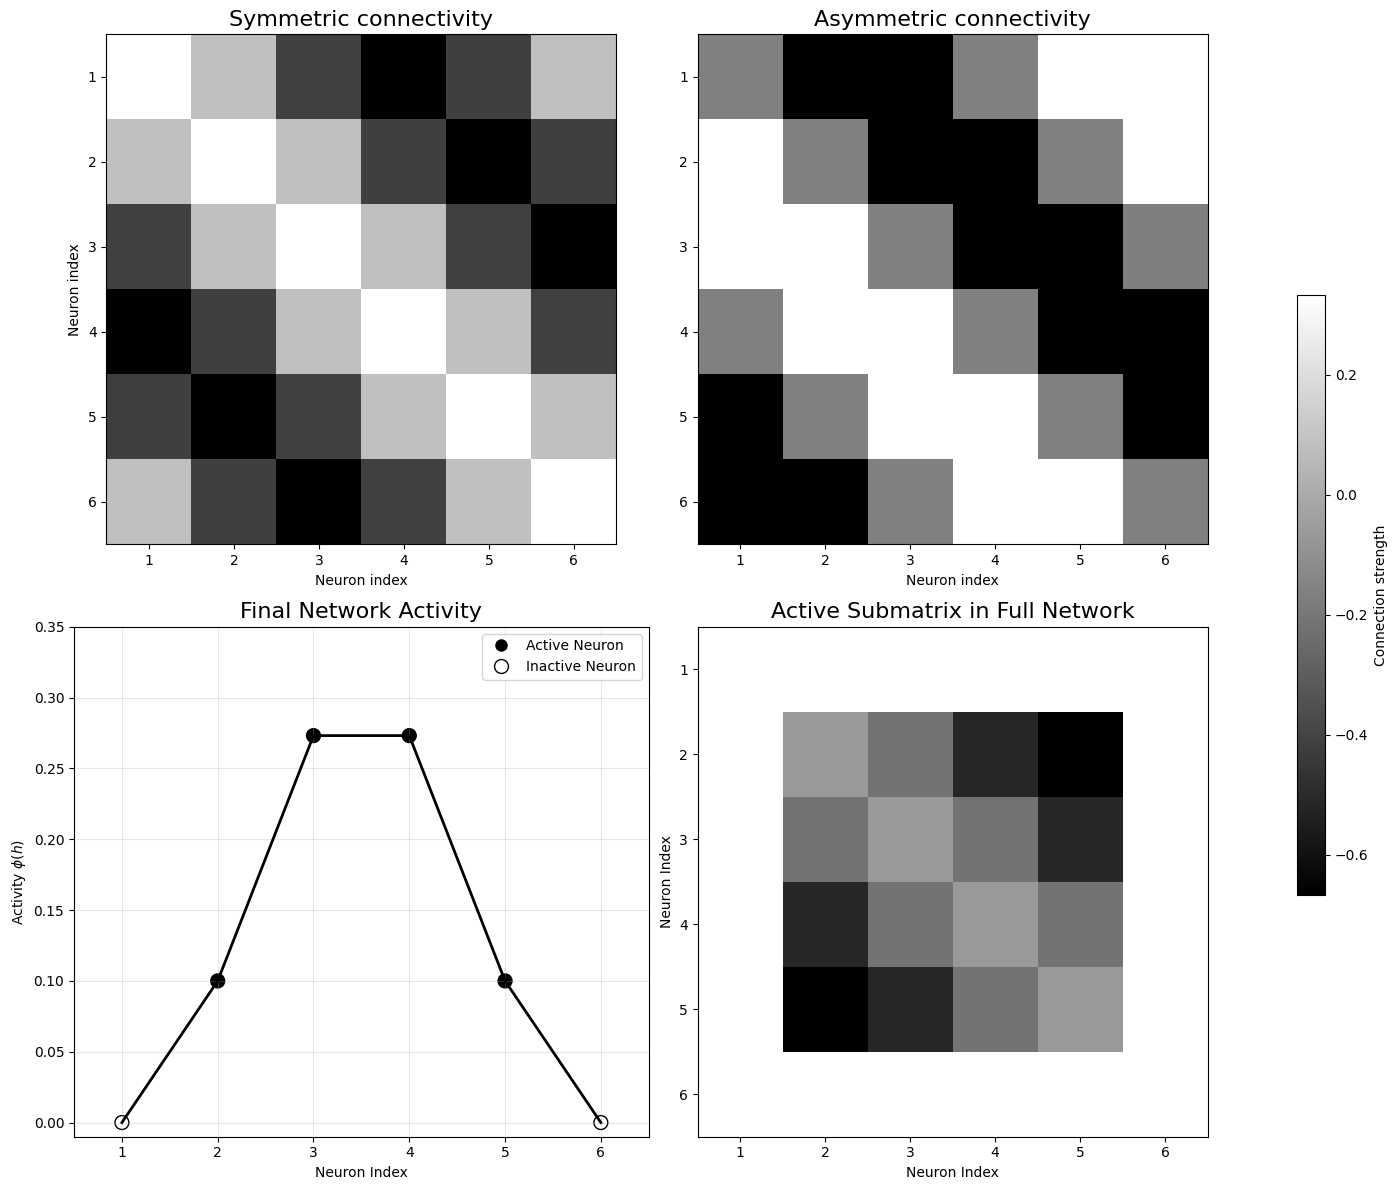

In [ ]:
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

# Calculate connectivity matrices using the existing function
N = 6
theta, W, W_cw, W_ccw, Ws, Wa = build_connectivity(N=N, JE=3.0, JI=-1.0)

# Ws = Ws * 6
# Wa = Wa * 6

# Create a 2x2 panel figure
fig = plt.figure(figsize=(14, 12))

# Panel 1: Symmetric connectivity (top-left)
ax1 = fig.add_subplot(2, 2, 1)
im1 = ax1.imshow(Ws, cmap='grey', aspect='equal')
ax1.set_title('Symmetric connectivity', fontsize=16)
ax1.set_xlabel('Neuron index')
ax1.set_ylabel('Neuron index')

# Panel 2: Asymmetric connectivity (top-right)
ax2 = fig.add_subplot(2, 2, 2)
im2 = ax2.imshow(Wa, cmap='grey', aspect='equal')
ax2.set_title('Asymmetric connectivity', fontsize=16)
ax2.set_xlabel('Neuron index')

# Set ticks for the top row panels
for ax in [ax1, ax2]:
    ax.set_xticks(range(N))
    ax.set_yticks(range(N))
    ax.set_xticklabels(range(1, N+1))
    ax.set_yticklabels(range(1, N+1))

# Initialize parameters for bottom panels
A = 0.2
width = 4 * 2 * np.pi / N
psi = 5 * np.pi / 6

# Initialize the starting activity with the bump
h0 = bump_init(theta, psi, width, A)
r0 = poslin(h0)

# Panel 3: Final Network Activity (bottom-left)
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(range(1, N+1), h0, 'k-', lw=2)
ax3.scatter(range(1, N+1), h0, s=100, c=['k' if h > 0 else 'w' for h in h0], edgecolors='k')
ax3.set_ylim(bottom=-0.01, top=0.35)
ax3.set_xlim(0.5, N+0.5)
ax3.set_xlabel('Neuron Index')
ax3.set_ylabel('Activity $\\phi(h)$')
ax3.set_title('Final Network Activity', fontsize=16)
ax3.grid(True, alpha=0.3)

# Add legend to the third panel
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=10, label='Active Neuron'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='w', markersize=10, markeredgecolor='k', label='Inactive Neuron')
]
ax3.legend(handles=legend_elements, loc='upper right')

# Panel 4: Active Submatrix (bottom-right)
ax4 = fig.add_subplot(2, 2, 4)

# Create a mask for highlighting the active submatrix
active_mask = r0 > 0
active_indices = np.where(active_mask)[0]
active_submatrix = W[np.ix_(active_indices, active_indices)]

# Create full matrix with active submatrix highlighted
full_matrix = np.ones((N, N))
for i, row_idx in enumerate(active_indices):
    for j, col_idx in enumerate(active_indices):
        full_matrix[row_idx, col_idx] = active_submatrix[i, j]

# Plot the full matrix with the active submatrix highlighted
im4 = ax4.imshow(full_matrix, cmap='grey', aspect='equal')
ax4.set_title('Active Submatrix in Full Network', fontsize=16)
ax4.set_xlabel("Neuron Index")
ax4.set_ylabel("Neuron Index")

# Set ticks for the bottom-right panel
ax4.set_xticks(range(N))
ax4.set_yticks(range(N))
ax4.set_xticklabels(range(1, N+1))
ax4.set_yticklabels(range(1, N+1))

# Add a single colorbar for the entire figure
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])  # Positioned to cover the middle of the figure
cbar = plt.colorbar(im1, cax=cbar_ax)
cbar.set_label('Connection strength')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('latex/connectivity_and_activity.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt



def run_attractor_simulation(JE, JI, N=6, tau=0.1, C0=1.0, A=0.2, v_in=1.5, timespan = (0.0, 2.0), n_centers=1000):
    """
    Run attractor simulation for given JE and JI values.
    
    Parameters
    ----------
    JE : float
        Excitatory connection strength
    JI : float
        Inhibitory connection strength
    N : int
        Number of neurons
    tau : float
        Time constant
    C0 : float
        Constant input
    A : float
        Amplitude of bump initialization
    v_in : float
        Velocity input
    n_centers : int
        Number of initial orientations to test
        
    Returns
    -------
    centers : ndarray
        Initial orientations
    attractors : ndarray
        Final attractor orientations
    final_states : ndarray
        Final activity states
    scores : ndarray
        PCA scores (first 3 components)
    """
    active_neurons = int(0.5 * N)  # Number of active neurons
    
    JE_opt, JE_inv, N_act = compute_opt_JE(N)

    if JE > JE_opt[int(0.5 * (N - 3))]:
        active_neurons = active_neurons - 1
    else:
        active_neurons = active_neurons + 1

    width = active_neurons * 2 * np.pi / N  # activate roughly 3 neurons
    theta, W, W_cw, W_ccw, Ws, Wa = build_connectivity(N, JE=JE, JI=JI)

    centers = np.linspace(-np.pi, np.pi, n_centers, endpoint=False)
    attractors = []
    final_states = []
    
    for psi in centers:
        h0 = bump_init(theta, psi, width, A)
        t, h = simulate_euler(
            W,
            W_cw,
            W_ccw,
            C0,
            tau,
            v_fn=lambda t: v_in,
            h0=h0,
            t_span=timespan,
            dt=0.01,
        )
        psi_traj, _, _ = compute_bump_state(h)
        attractors.append(psi_traj[-1])
        final_states.append(h[:, -1])

    final_states = np.stack(final_states)
    attractors = np.array(attractors)

    
    # Compute PCA
    # Compute PCA using our manual method
    eigvals, eigvecs, scores = pca_from_scratch(final_states)
    # Normalize scores for visualization
    scores = scores - np.mean(scores, axis=0)
    scores = scores / np.std(scores, axis=0)
    scores = scores[:, 0:3]  # use only first 3 components

    # Run PCA using scikit-learn
    pca = PCA(n_components=N)  # We only need 3 components for visualization
    sklearn_scores = pca.fit_transform(final_states)

    # Normalize sklearn scores for consistency with manual PCA
    sklearn_scores = sklearn_scores - np.mean(sklearn_scores, axis=0)
    sklearn_scores = sklearn_scores / np.std(sklearn_scores, axis=0)
    sklearn_eigenvecs = pca.components_.T  
    # Print explained variance ratio from scikit-learn PCA


    cosine_alignment = np.abs(np.dot(eigvecs.T, sklearn_eigenvecs))

    print(f"Explained variance ratio: {pca.explained_variance_ratio_[:3]}")

    # print explained variance from manual PCA
    print(f"Explained variance from manual PCA: {eigvals[:3] / np.sum(eigvals)}")
    
    # Compare the two PCA implementations
    print(f"Correlation between manual PCA and scikit-learn PCA:")
    for i in range(3):
        corr = np.abs(np.corrcoef(scores[:, i], sklearn_scores[:, i])[0, 1])
        print(f"Component {i+1}: {corr:.6f}")
    
    return centers, attractors, final_states, scores, sklearn_scores, cosine_alignment


In [65]:
# Calculate number of parameter combinations
def plot_attractor_map(ax, centers, attractors, JE, combination_idx, n_combinations):
    """Plot attractor map"""
    scatter = ax.scatter(centers, attractors, s=20)
    
    # Only add ylabel to the leftmost subplot
    if combination_idx == 0:
        ax.set_ylabel('Final orientation', fontsize=14)
    
    ax.set_title(f'Attractor Map (JE={JE:.2f})', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax.set_xlabel('Initial orientation', fontsize=14)
    ax.set_xticklabels(['-π', '-π/2', '0', 'π/2', 'π'], fontsize=12)
    ax.set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'], fontsize=12)
    
    return scatter

def plot_manual_pca(ax, scores, centers, JE, combination_idx, n_combinations):
    """Plot manual PCA 3D"""
    scatter = ax.scatter(scores[:, 0], scores[:, 1], scores[:, 2], 
                        c=centers, cmap='hsv', s=20, vmin=-np.pi, vmax=np.pi)
    
    # Only add labels to the leftmost subplot
    if combination_idx == 0:
        ax.set_ylabel('PC2', fontsize=14)
        ax.set_zlabel('PC3', fontsize=14)
    
    ax.set_title(f'Manual PCA (JE={JE:.2f})', fontsize=16)
    ax.set_xlabel('PC1', fontsize=14)
    ax.set_zlim(-6, 6)
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    return scatter

def plot_sklearn_pca(ax, sklearn_scores, centers, JE, combination_idx, n_combinations):
    """Plot sklearn PCA 3D"""
    scatter = ax.scatter(sklearn_scores[:, 0], sklearn_scores[:, 1], sklearn_scores[:, 2], 
                        c=centers, cmap='hsv', s=20, vmin=-np.pi, vmax=np.pi)
    
    # Only add labels to the leftmost subplot
    if combination_idx == 0:
        ax.set_ylabel('PC2', fontsize=14)
        ax.set_zlabel('PC3', fontsize=14)
    
    ax.set_title(f'Sklearn PCA (JE={JE:.2f})', fontsize=16)
    ax.set_xlabel('PC1', fontsize=14)
    ax.set_zlim(-6, 6)
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    return scatter


Running simulation for JE=4, JI=-2.05
Explained variance ratio: [4.99899555e-01 4.99896782e-01 2.03663767e-04]
Explained variance from manual PCA: [4.99899555e-01 4.99896782e-01 2.03663767e-04]
Correlation between manual PCA and scikit-learn PCA:
Component 1: 1.000000
Component 2: 1.000000
Component 3: 1.000000


/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_20868/4249450686.py:95: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 2 Axes> than <Figure size 800x600 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_20868/4249450686.py:95: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 2 Axes> than <Figure size 800x600 with 2 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)


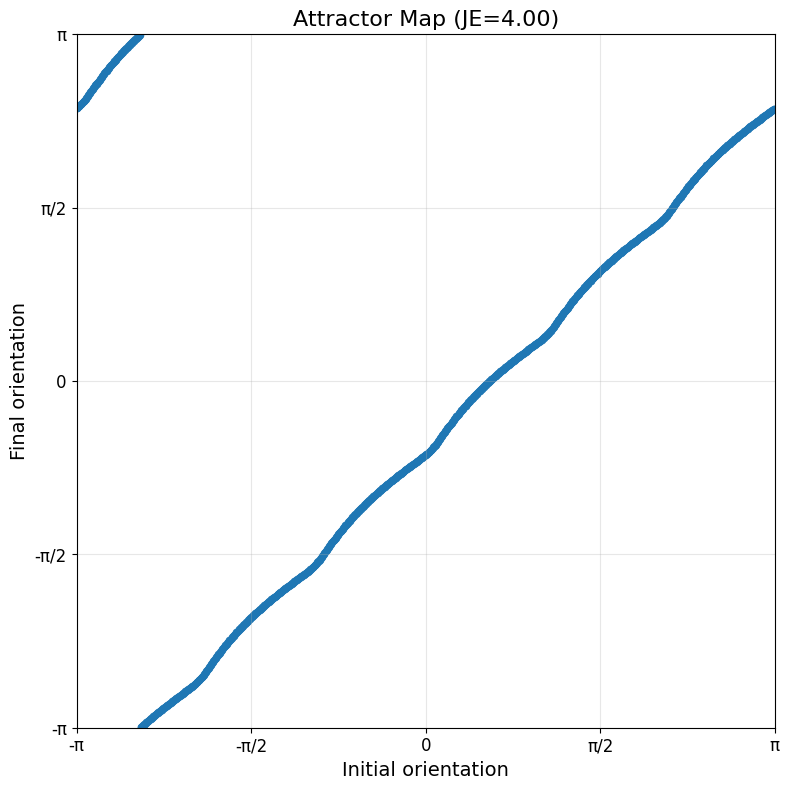

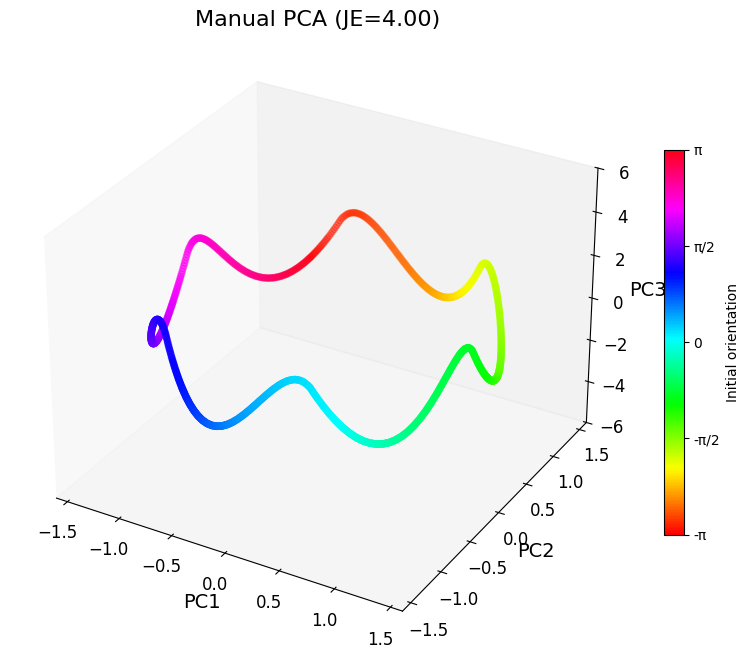

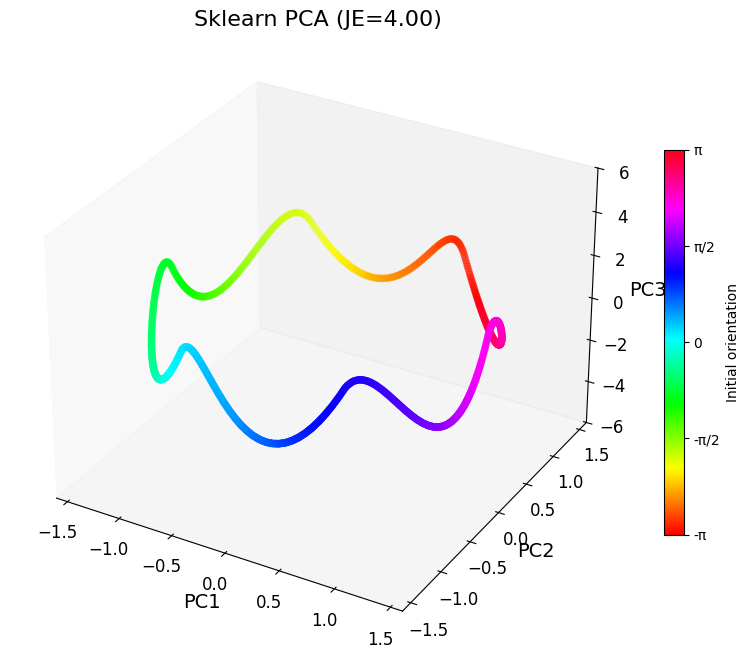

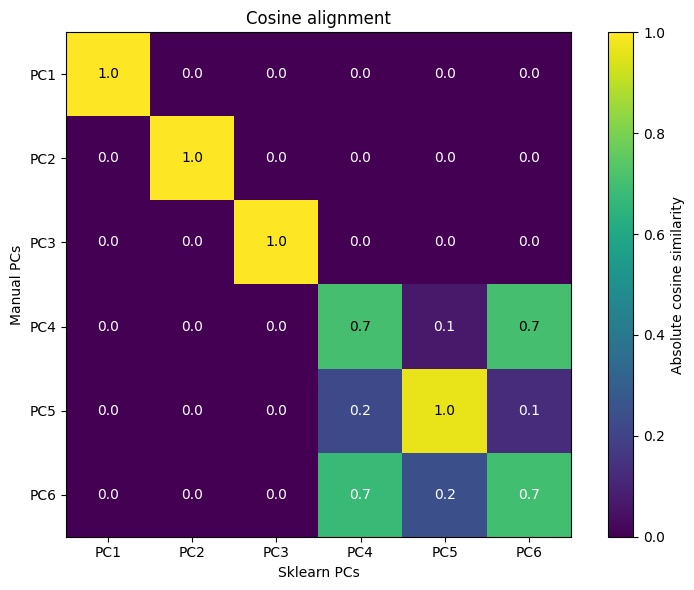

In [68]:

# Define parameter ranges to iterate over
# JE_values = [12,6, 4, 3, 2.4]
JE_values = [4]

# inverse_JE_values = [0.10, 0.15, 0.20, 0.25, 0.35, 0.55]
# JE_values = 1 / np.array(inverse_JE_values)  # Convert to JE values
JI_values = [ -2.05]  # Inhibitory connection strengths

# Store results
results = {}

N = 6 # Number of neurons
tau = 0.1
C0 = 1.0
A = 0.2 # Amplitude of the bump
v_in =1.5  # Constant velocity input

n_combinations = len(JE_values) * len(JI_values)
# Create three separate figures: one for attractor maps, one for manual PCA, and one for sklearn PCA
fig_attractor = plt.figure(figsize=(8 * n_combinations, 8))  # For attractor maps
fig_pca_manual = plt.figure(figsize=(8 * n_combinations, 8))  # For manual PCA plots
fig_pca_sklearn = plt.figure(figsize=(8 * n_combinations, 8))  # For sklearn PCA plots

combination_idx = 0

for JE in JE_values:
    for JI in JI_values:
        print(f"Running simulation for JE={JE}, JI={JI}")
        centers, attractors, final_states, scores, sklearn_scores, cosine_alignment = run_attractor_simulation(JE, JI, 
                                                                                             N=N, tau=tau, C0=C0, A=A, 
                                                                                             v_in=v_in, timespan = (0.0,3.0), 
                                                                                             n_centers=1000)
        
        # Store results
        results[(JE, JI)] = {
            'centers': centers,
            'attractors': attractors,
            'final_states': final_states,
            'scores': scores
        }
        


        # Create a new figure for cosine alignment matrix visualization
        fig_alignment = plt.figure(figsize=(8, 6))
        ax_alignment = fig_alignment.add_subplot(111)

        # Create a heatmap of the cosine alignment matrix
        im = ax_alignment.imshow(cosine_alignment, cmap='viridis', vmin=0, vmax=1)
        plt.colorbar(im, label='Absolute cosine similarity')

        # Set labels and title
        ax_alignment.set_xlabel('Sklearn PCs')
        ax_alignment.set_ylabel('Manual PCs')
        ax_alignment.set_title(f'Cosine alignment')

        # Set ticks
        ax_alignment.set_xticks(np.arange(cosine_alignment.shape[1]))
        ax_alignment.set_yticks(np.arange(cosine_alignment.shape[0]))
        ax_alignment.set_xticklabels([f'PC{i+1}' for i in range(cosine_alignment.shape[1])])
        ax_alignment.set_yticklabels([f'PC{i+1}' for i in range(cosine_alignment.shape[0])])

        # Add text annotations for alignment values
        for i in range(cosine_alignment.shape[0]):
            for j in range(cosine_alignment.shape[1]):
                text = ax_alignment.text(j, i, f'{cosine_alignment[i, j]:.1f}',
                                        ha='center', va='center', color='white' if cosine_alignment[i, j] < 0.7 else 'black')

        plt.tight_layout()
        fig_alignment.savefig(f'latex/cosine_alignment.png', dpi=300, bbox_inches='tight')


        

        # Plot attractor map
        ax1 = fig_attractor.add_subplot(1, n_combinations, combination_idx + 1)
        scatter1 = plot_attractor_map(ax1, centers, attractors, JE, combination_idx, n_combinations)
        # Save the figure instead of the axes
        fig_attractor.savefig('latex/orientation_comparison.png', dpi=300, bbox_inches='tight')

        # Plot manual PCA 3D
        ax2 = fig_pca_manual.add_subplot(1, n_combinations, combination_idx + 1, projection='3d')
        scatter2 = plot_manual_pca(ax2, scores, centers, JE, combination_idx, n_combinations)
        fig_pca_manual.savefig('latex/manual_pca.png', dpi=300, bbox_inches='tight')

        # Plot sklearn PCA 3D
        ax3 = fig_pca_sklearn.add_subplot(1, n_combinations, combination_idx + 1, projection='3d')
        scatter3 = plot_sklearn_pca(ax3, sklearn_scores, centers, JE, combination_idx, n_combinations)
        fig_pca_sklearn.savefig('latex/sklearn_pca.png', dpi=300, bbox_inches='tight')
        
        # Add colorbar only to the last subplot in each figure
        if combination_idx == n_combinations - 1:
            for fig, ax, scatter in [(fig_pca_manual, ax2, scatter2), 
                                     (fig_pca_sklearn, ax3, scatter3)]:
                cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
                cbar.set_label('Initial orientation')
                cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
                cbar.set_ticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
        
        combination_idx += 1

fig_attractor.tight_layout()
fig_pca_manual.tight_layout()
fig_pca_sklearn.tight_layout()
plt.show()

Running simulation for JE=10.0, JI=-2.0, C0=1.0, v_in=0.0
Explained variance ratio: [0.49876934 0.49854328 0.00268738]
Explained variance from manual PCA: [0.49876934 0.49854328 0.00268738]
Correlation between manual PCA and scikit-learn PCA:
Component 1: 1.000000
Component 2: 1.000000
Component 3: 1.000000
Running simulation for JE=6.666666666666667, JI=-2.0, C0=1.0, v_in=0.0
Explained variance ratio: [5.00344111e-01 4.99198144e-01 4.57744789e-04]
Explained variance from manual PCA: [5.00344111e-01 4.99198144e-01 4.57744789e-04]
Correlation between manual PCA and scikit-learn PCA:
Component 1: 1.000000
Component 2: 1.000000
Component 3: 1.000000
Running simulation for JE=5.0, JI=-2.0, C0=1.0, v_in=0.0
Explained variance ratio: [5.00186274e-01 4.99795032e-01 1.86946987e-05]
Explained variance from manual PCA: [5.00186274e-01 4.99795032e-01 1.86946987e-05]
Correlation between manual PCA and scikit-learn PCA:
Component 1: 1.000000
Component 2: 1.000000
Component 3: 1.000000
Running simul

/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_20868/1014801563.py:54: UserWarning: Adding colorbar to a different Figure <Figure size 1800x400 with 7 Axes> than <Figure size 1800x400 with 6 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)


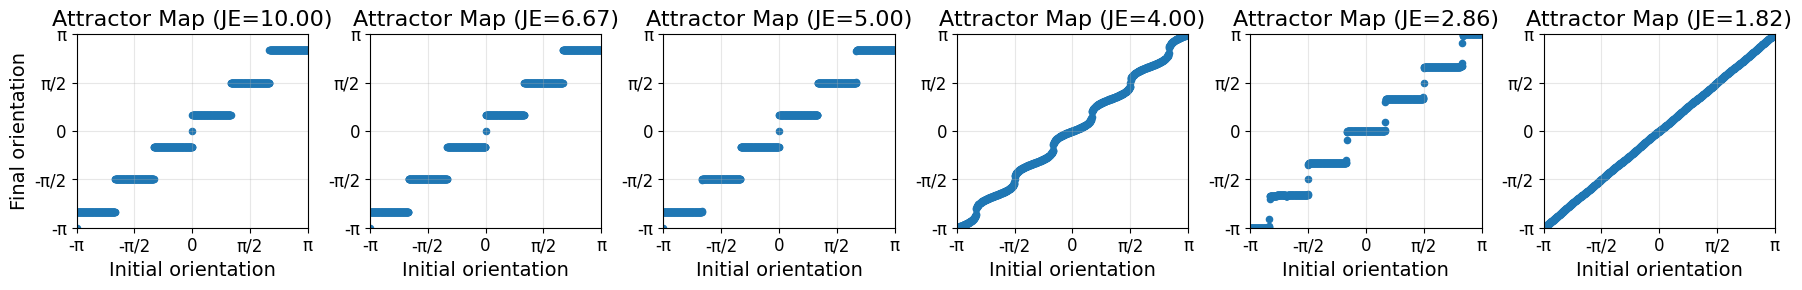

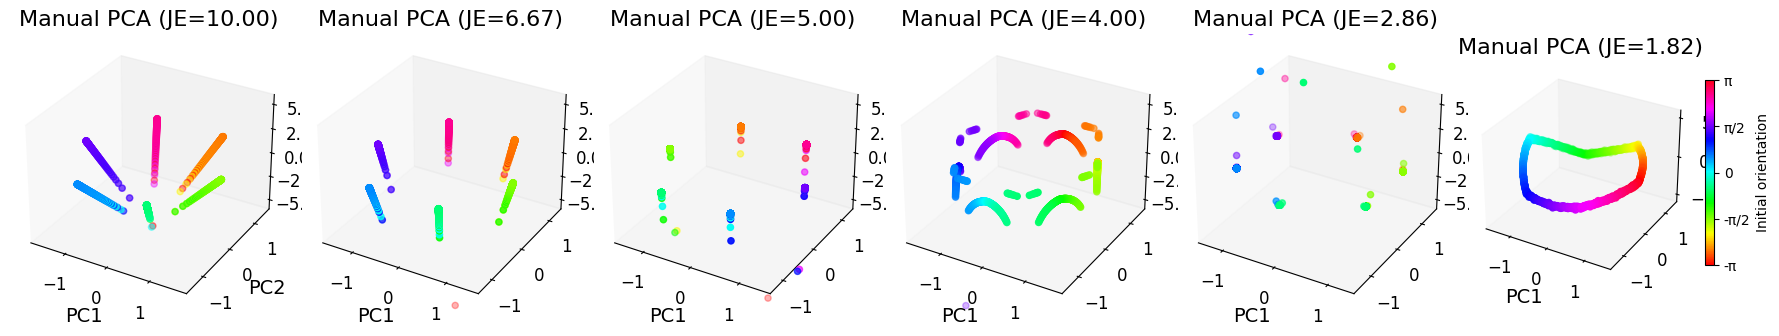

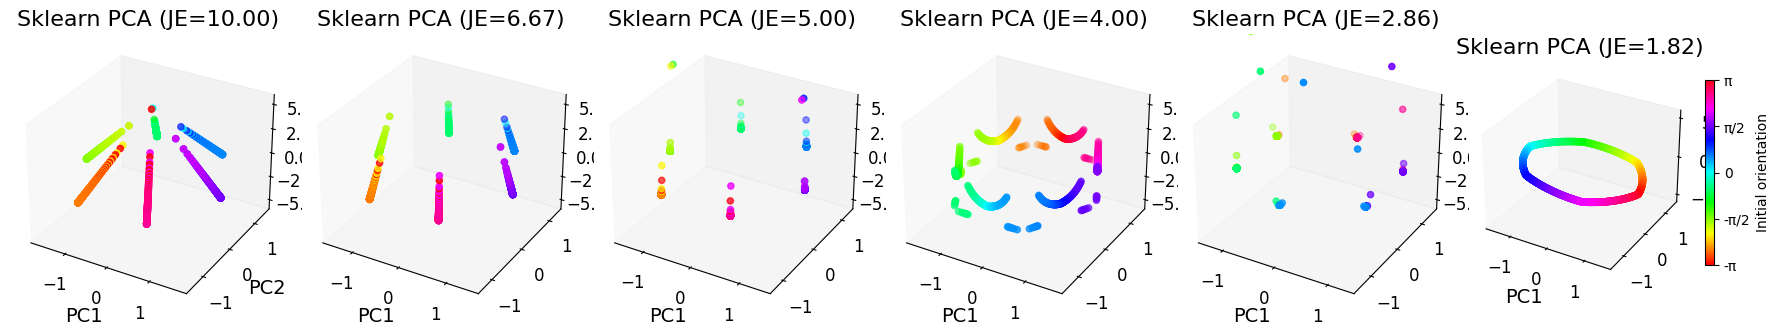

In [ ]:
# Define parameter ranges to iterate over
# JE_values = [ 12, 6, 4, 2.4, 1.4]
inverse_JE_values = [0.10, 0.15, 0.20, 0.25, 0.35, 0.55]
JE_values = 1 / np.array(inverse_JE_values)  # Convert to JE values
JI_values = [ -2.0]  # Inhibitory connection strengths


# Store results
results = {}

N = 6 # Number of neurons
tau = 0.1
C0 = 1.0
A = 0.2 # Amplitude of the bump
v_in = 0.0  # Constant velocity input

n_combinations = len(JE_values) * len(JI_values)
# Create three separate figures: one for attractor maps, one for manual PCA, and one for sklearn PCA
fig_attractor = plt.figure(figsize=(3 * n_combinations, 3))  # For attractor maps
fig_pca_manual = plt.figure(figsize=(3 * n_combinations, 4))  # For manual PCA plots
# fig_pca_sklearn = plt.figure(figsize=(3 * n_combinations, 4))  # For sklearn PCA plots

combination_idx = 0

for JE in JE_values:
    for JI in JI_values:
        print(f"Running simulation for JE={JE}, JI={JI}, C0={C0}, v_in={v_in}")
        centers, attractors, final_states, scores, sklearn_scores, _ = run_attractor_simulation(JE, JI, N=N, tau=tau, C0=C0, A=A, v_in=v_in, timespan = (0.0,3.0), n_centers=1000)
        
        # Store results
        results[(JE, JI)] = {
            'centers': centers,
            'attractors': attractors,
            'final_states': final_states,
            'scores': scores
        }
        
        # Plot attractor map
        ax1 = fig_attractor.add_subplot(1, n_combinations, combination_idx + 1)
        scatter1 = plot_attractor_map(ax1, centers, attractors, JE, combination_idx, n_combinations)

        # Plot manual PCA 3D
        ax2 = fig_pca_manual.add_subplot(1, n_combinations, combination_idx + 1, projection='3d')
        scatter2 = plot_manual_pca(ax2, scores, centers, JE, combination_idx, n_combinations)

        # Plot sklearn PCA 3D
        # ax3 = fig_pca_sklearn.add_subplot(1, n_combinations, combination_idx + 1, projection='3d')
        # scatter3 = plot_sklearn_pca(ax3, sklearn_scores, centers, JE, combination_idx, n_combinations)
        
        # Add colorbar only to the last subplot in each figure
        if combination_idx == n_combinations - 1:
            for fig, ax, scatter in [(fig_pca_manual, ax2, scatter2), 
                                     (fig_pca_sklearn, ax3, scatter3)]:
                cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
                cbar.set_label('Initial orientation')
                cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
                cbar.set_ticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
        
        combination_idx += 1

fig_attractor.tight_layout()
fig_pca_manual.tight_layout()
fig_pca_sklearn.tight_layout()
plt.show()



Running simulation for JE=12, JI=-4.05
Explained variance ratio: [0.49663744 0.49632986 0.0070327 ]
Explained variance from manual PCA: [0.49663744 0.49632986 0.0070327 ]
Correlation between manual PCA and scikit-learn PCA:
Component 1: 1.000000
Component 2: 1.000000
Component 3: 1.000000
Running simulation for JE=8, JI=-4.05
Explained variance ratio: [0.47990829 0.47989643 0.04019528]
Explained variance from manual PCA: [0.47990829 0.47989643 0.04019528]
Correlation between manual PCA and scikit-learn PCA:
Component 1: 1.000000
Component 2: 1.000000
Component 3: 1.000000
Running simulation for JE=4, JI=-4.05
Explained variance ratio: [5.00999989e-01 4.99000011e-01 4.69036339e-13]
Explained variance from manual PCA: [5.00999989e-01 4.99000011e-01 4.66860159e-13]
Correlation between manual PCA and scikit-learn PCA:
Component 1: 1.000000
Component 2: 1.000000
Component 3: 1.000000
Running simulation for JE=2.4, JI=-4.05
Explained variance ratio: [5.00337647e-01 4.99504906e-01 1.57446646e

/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_20868/2203273933.py:53: UserWarning: Adding colorbar to a different Figure <Figure size 1500x400 with 6 Axes> than <Figure size 1500x400 with 5 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)


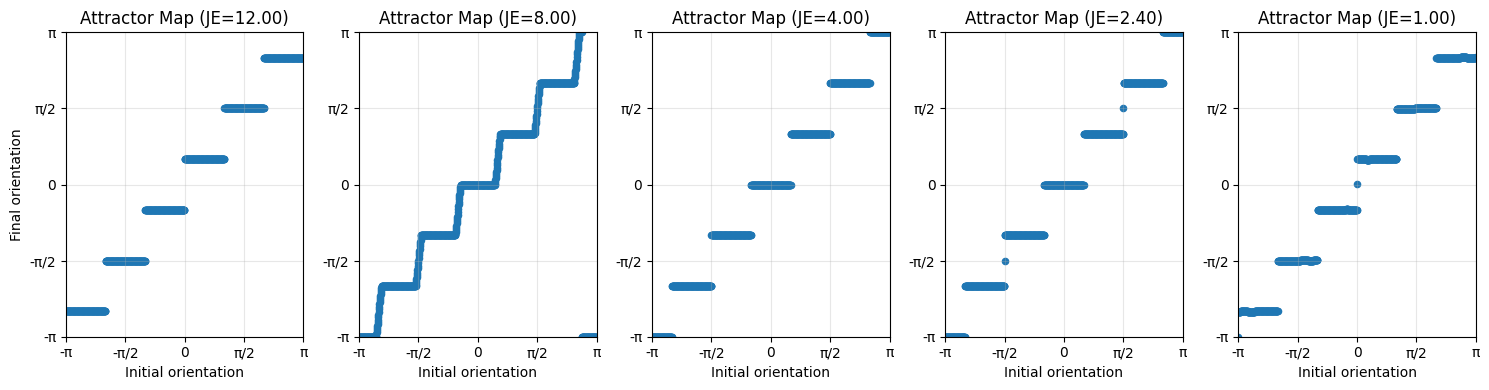

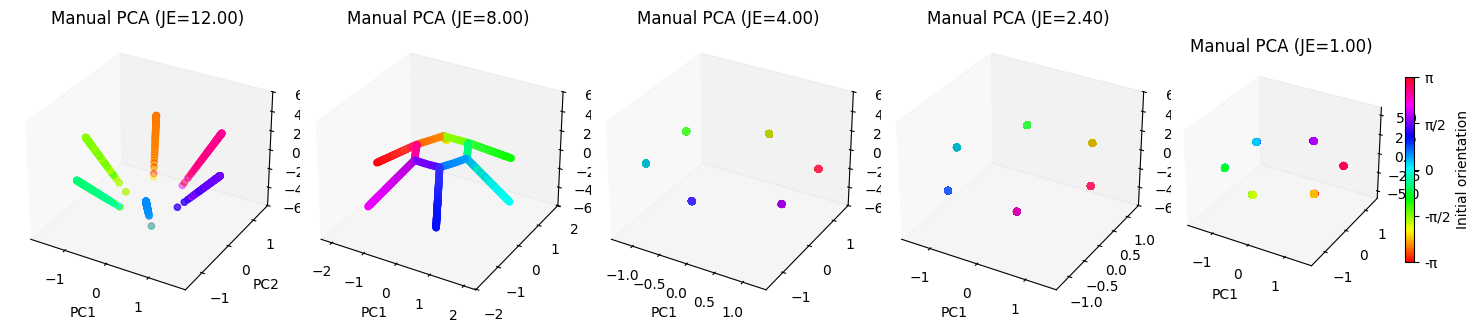

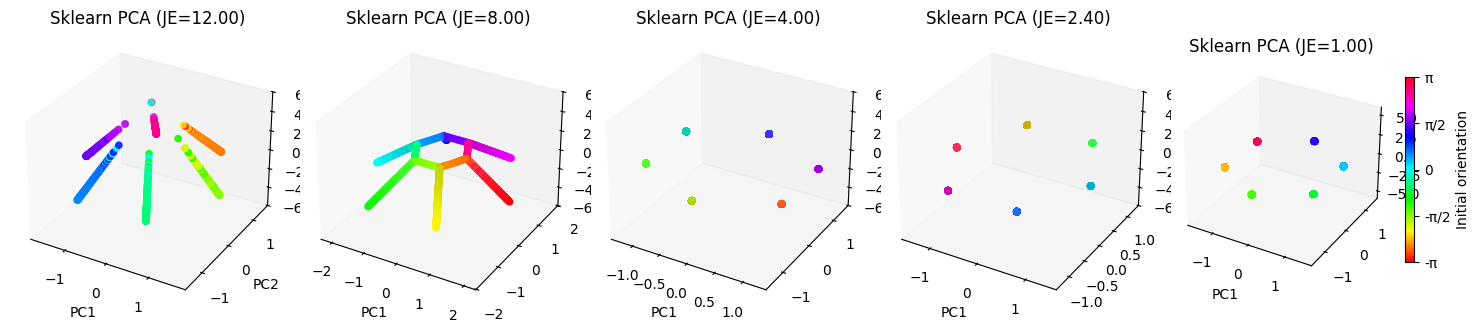

In [10]:

# Define parameter ranges to iterate over
JE_values = [12, 8, 4,  2.4, 1.0]
# inverse_JE_values = [0.10, 0.15, 0.20, 0.25, 0.35, 0.55]
# JE_values = 1 / np.array(inverse_JE_values)  # Convert to JE values
JI_values = [ -4.05]  # Inhibitory connection strengths

# Store results
results = {}

N = 6 # Number of neurons
tau = 0.1
C0 = 1.0
A = 0.2 # Amplitude of the bump
v_in = 0  # Constant velocity input

n_combinations = len(JE_values) * len(JI_values)
# Create three separate figures: one for attractor maps, one for manual PCA, and one for sklearn PCA
fig_attractor = plt.figure(figsize=(3 * n_combinations, 4))  # For attractor maps
fig_pca_manual = plt.figure(figsize=(3 * n_combinations, 4))  # For manual PCA plots
fig_pca_sklearn = plt.figure(figsize=(3 * n_combinations, 4))  # For sklearn PCA plots

combination_idx = 0

for JE in JE_values:
    for JI in JI_values:
        print(f"Running simulation for JE={JE}, JI={JI}")
        centers, attractors, final_states, scores, sklearn_scores = run_attractor_simulation(JE, JI, N=N, tau=tau, C0=C0, A=A, v_in=v_in, timespan=(0.0,3.0), n_centers=1000)
        
        # Store results
        results[(JE, JI)] = {
            'centers': centers,
            'attractors': attractors,
            'final_states': final_states,
            'scores': scores
        }
        
        # Plot attractor map
        ax1 = fig_attractor.add_subplot(1, n_combinations, combination_idx + 1)
        scatter1 = plot_attractor_map(ax1, centers, attractors, JE, combination_idx, n_combinations)

        # Plot manual PCA 3D
        ax2 = fig_pca_manual.add_subplot(1, n_combinations, combination_idx + 1, projection='3d')
        scatter2 = plot_manual_pca(ax2, scores, centers, JE, combination_idx, n_combinations)

        # Plot sklearn PCA 3D
        ax3 = fig_pca_sklearn.add_subplot(1, n_combinations, combination_idx + 1, projection='3d')
        scatter3 = plot_sklearn_pca(ax3, sklearn_scores, centers, JE, combination_idx, n_combinations)
        
        # Add colorbar only to the last subplot in each figure
        if combination_idx == n_combinations - 1:
            for fig, ax, scatter in [(fig_pca_manual, ax2, scatter2), 
                                     (fig_pca_sklearn, ax3, scatter3)]:
                cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
                cbar.set_label('Initial orientation')
                cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
                cbar.set_ticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
        
        combination_idx += 1

fig_attractor.tight_layout()
fig_pca_manual.tight_layout()
fig_pca_sklearn.tight_layout()
plt.show()

Running simulation for JE=65.70377499257457, JI=-1


/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_2648/2659110603.py:174: RuntimeWarning: overflow encountered in matmul
  cov = Xc.T @ Xc / (Xc.shape[0] - 1)
/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_2648/2659110603.py:174: RuntimeWarning: invalid value encountered in matmul
  cov = Xc.T @ Xc / (Xc.shape[0] - 1)
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:608: RuntimeWarning: overflow encountered in multiply
  n_samples
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/sklear

Explained variance ratio: [nan nan nan]
Explained variance from manual PCA: [nan nan nan]
Correlation between manual PCA and scikit-learn PCA:
Component 1: nan
Component 2: nan
Component 3: nan
Running simulation for JE=31.465728923122416, JI=-1


/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_2648/2659110603.py:174: RuntimeWarning: overflow encountered in matmul
  cov = Xc.T @ Xc / (Xc.shape[0] - 1)
/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_2648/2659110603.py:174: RuntimeWarning: invalid value encountered in matmul
  cov = Xc.T @ Xc / (Xc.shape[0] - 1)
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:608: RuntimeWarning: overflow encountered in multiply
  n_samples
/Users/sepehr/Desktop/Ecole Normale/S2/CompNeuroMethods/.venv/lib/python3.9/site-packages/sklear

Explained variance ratio: [nan nan nan]
Explained variance from manual PCA: [nan nan nan]
Correlation between manual PCA and scikit-learn PCA:
Component 1: nan
Component 2: nan
Component 3: nan
Running simulation for JE=17.85776480299074, JI=-1
Explained variance ratio: [4.99999999e-01 4.99999999e-01 1.33069540e-09]
Explained variance from manual PCA: [4.99999999e-01 4.99999999e-01 1.33069560e-09]
Correlation between manual PCA and scikit-learn PCA:
Component 1: 0.999997
Component 2: 0.999997
Component 3: 1.000000
Running simulation for JE=11.3702579218686, JI=-1
Explained variance ratio: [4.99999997e-01 4.99999997e-01 6.62075169e-09]
Explained variance from manual PCA: [4.99999997e-01 4.99999997e-01 6.62075155e-09]
Correlation between manual PCA and scikit-learn PCA:
Component 1: 1.000000
Component 2: 1.000000
Component 3: 1.000000


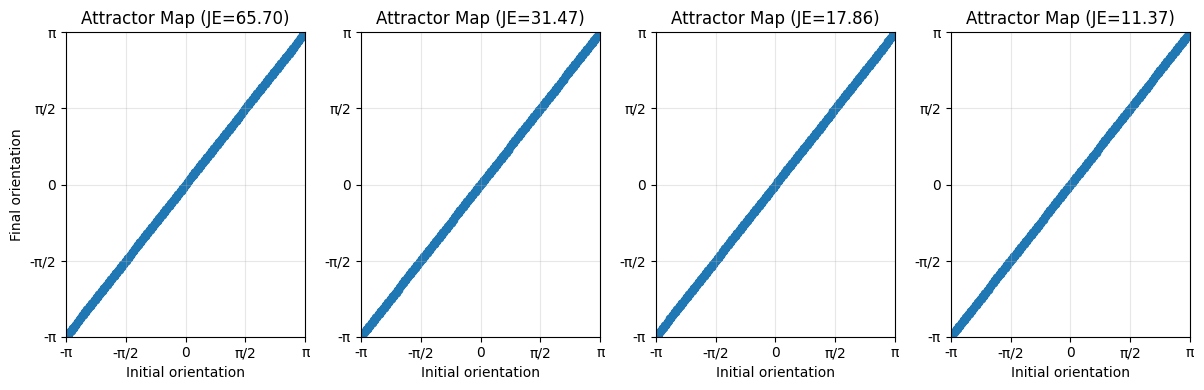

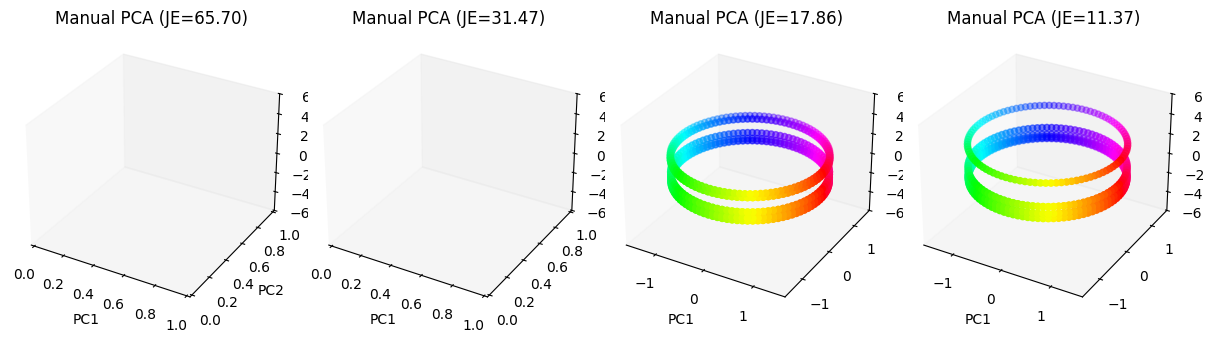

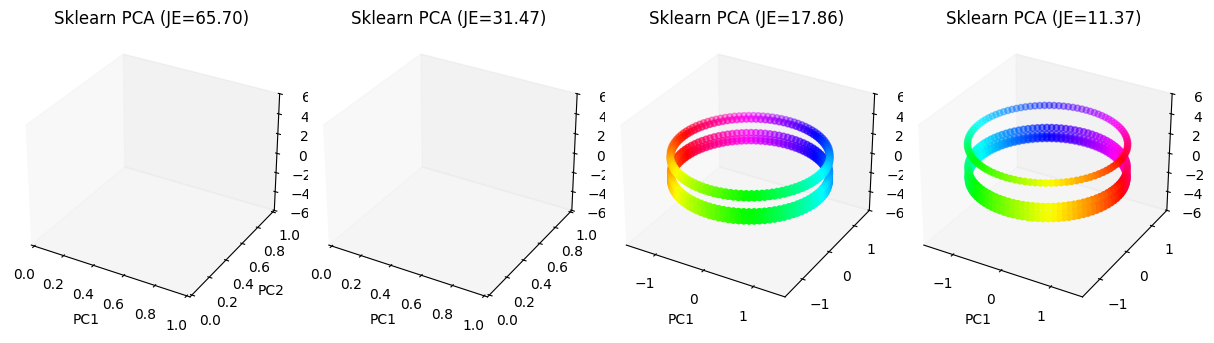

In [14]:

# Define parameter ranges to iterate over
JE_values = [12, 6, 4, 3, 2.4, 1.4]
# inverse_JE_values = [0.10, 0.15, 0.20, 0.25, 0.35, 0.55]
# JE_values = 1 / np.array(inverse_JE_values)  # Convert to JE values
JI_values = [ -1]  # Inhibitory connection strengths

# Store results
results = {}

N = 100 # Number of neurons
JE_opt, JE_inv, N_act = compute_opt_JE(N=N)
tau = 0.1
C0 = 1.0
A = 0.2 # Amplitude of the bump
v_in = 0  # Constant velocity input

n_combinations = len(JE_values) * len(JI_values)
# Create three separate figures: one for attractor maps, one for manual PCA, and one for sklearn PCA
fig_attractor = plt.figure(figsize=(3 * n_combinations, 4))  # For attractor maps
fig_pca_manual = plt.figure(figsize=(3 * n_combinations, 4))  # For manual PCA plots
fig_pca_sklearn = plt.figure(figsize=(3 * n_combinations, 4))  # For sklearn PCA plots

combination_idx = 0

for JE in JE_opt[15:35:5]:
    for JI in JI_values:
        print(f"Running simulation for JE={JE}, JI={JI}")
        centers, attractors, final_states, scores, sklearn_scores = run_attractor_simulation(JE, JI, N=N, tau=tau, C0=C0, A=A, v_in=v_in, n_centers=1000)
        
        # Store results
        results[(JE, JI)] = {
            'centers': centers,
            'attractors': attractors,
            'final_states': final_states,
            'scores': scores
        }
        
        # Plot attractor map
        ax1 = fig_attractor.add_subplot(1, n_combinations, combination_idx + 1)
        scatter1 = plot_attractor_map(ax1, centers, attractors, JE, combination_idx, n_combinations)

        # Plot manual PCA 3D
        ax2 = fig_pca_manual.add_subplot(1, n_combinations, combination_idx + 1, projection='3d')
        scatter2 = plot_manual_pca(ax2, scores, centers, JE, combination_idx, n_combinations)

        # Plot sklearn PCA 3D
        ax3 = fig_pca_sklearn.add_subplot(1, n_combinations, combination_idx + 1, projection='3d')
        scatter3 = plot_sklearn_pca(ax3, sklearn_scores, centers, JE, combination_idx, n_combinations)
        
        # Add colorbar only to the last subplot in each figure
        if combination_idx == n_combinations - 1:
            for fig, ax, scatter in [(fig_pca_manual, ax2, scatter2), 
                                     (fig_pca_sklearn, ax3, scatter3)]:
                cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
                cbar.set_label('Initial orientation')
                cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
                cbar.set_ticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
        
        combination_idx += 1

fig_attractor.tight_layout()
fig_pca_manual.tight_layout()
fig_pca_sklearn.tight_layout()
plt.show()

In [783]:
JE_opt[20:40:5]

array([31.46572892, 17.8577648 , 11.37025792,  7.87697219])

In [759]:
JE_opt

array([52.36067977, 14.47213595,  6.66666667,  4.        ,  2.85714286,
        2.32071491,  2.07942705])